
<div dir=ltr align=center>
<br>
<font size=8>
IntersectNET: Traffic Flow? Managed<br>
<font size=5>
Arshia Gharooni

# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Simulation Parameters

In [2]:
simulation_time = 3600
delta_t = 5
num_steps = int(simulation_time // delta_t)
delta_x = 250
v_max = 16.67

# Define Edge and Intersection Classes and Initialize the Traffic Network

In [3]:
class Edge:
    def __init__(self, edge_id, length, capacity, free_flow_speed, congestion_wave_speed, max_density):
        self.edge_id = edge_id
        self.length = length
        self.capacity = capacity
        self.free_flow_speed = free_flow_speed
        self.congestion_wave_speed = congestion_wave_speed
        self.max_density = max_density
        self.num_cells = int(np.ceil(self.length / delta_x))
        self.delta_x = self.length / self.num_cells
        self.density = np.zeros(self.num_cells)
        self.flow = np.zeros(self.num_cells + 1)


        self.speed = np.zeros(self.num_cells)
        self.total_flow = np.zeros(num_steps)
        self.total_density = np.zeros(num_steps)
        self.average_speed = np.zeros(num_steps)
        self.cumulative_flow = np.zeros(num_steps)
        self.initial_density = None
        self.optimized_density = None

    def calculate_capacity(self):
        return min(self.free_flow_speed * self.max_density / 4, self.capacity)


class Intersection:
    def __init__(self, node_id, incoming_edges, outgoing_edges, transition_matrix=None):
        self.node_id = node_id
        self.incoming_edges = incoming_edges
        self.outgoing_edges = outgoing_edges
        self.transition_matrix = transition_matrix

        self.flow_history = []

edges = {
    'E1': Edge('E1', length=2000, capacity=2000 * delta_t / 3600, free_flow_speed=16.67, congestion_wave_speed=-5, max_density=0.2),
    'E2': Edge('E2', length=1500, capacity=1800 * delta_t / 3600, free_flow_speed=15.0, congestion_wave_speed=-5, max_density=0.2),
    'E3': Edge('E3', length=2500, capacity=2200 * delta_t / 3600, free_flow_speed=13.89, congestion_wave_speed=-5, max_density=0.2),
    'E4': Edge('E4', length=1800, capacity=2000 * delta_t / 3600, free_flow_speed=16.67, congestion_wave_speed=-5, max_density=0.2),
    'E5': Edge('E5', length=1200, capacity=1500 * delta_t / 3600, free_flow_speed=12.5, congestion_wave_speed=-5, max_density=0.2),
    'E6': Edge('E6', length=2200, capacity=2000 * delta_t / 3600, free_flow_speed=14.0, congestion_wave_speed=-5, max_density=0.2),
    'E7': Edge('E7', length=2000, capacity=1900 * delta_t / 3600, free_flow_speed=13.89, congestion_wave_speed=-5, max_density=0.2),
    'E8': Edge('E8', length=1500, capacity=1800 * delta_t / 3600, free_flow_speed=15.28, congestion_wave_speed=-5, max_density=0.2),
    'E9': Edge('E9', length=2500, capacity=2000 * delta_t / 3600, free_flow_speed=16.67, congestion_wave_speed=-5, max_density=0.2),
}

intersections = {
    'I1': Intersection('I1', incoming_edges=['E1', 'E2'], outgoing_edges=['E3']),
    'I2': Intersection('I2', incoming_edges=['E3'], outgoing_edges=['E4', 'E5']),
    'I3': Intersection('I3', incoming_edges=['E4'], outgoing_edges=['E6']),
    'I4': Intersection('I4', incoming_edges=['E5'], outgoing_edges=['E7']),
    'I5': Intersection('I5', incoming_edges=['E6', 'E7'], outgoing_edges=['E8']),
    'I6': Intersection('I6', incoming_edges=['E8'], outgoing_edges=['E9']),
}

for intersection in intersections.values():
    num_in = len(intersection.incoming_edges)
    num_out = len(intersection.outgoing_edges)
    intersection.transition_matrix = np.full((num_out, num_in), 1.0 / num_out)

# Cell Transmission Model Function

In [4]:
def cell_transmission_model(edge):
    S = np.zeros(edge.num_cells)
    R = np.zeros(edge.num_cells)
    Q_max = edge.calculate_capacity()
    w = -edge.congestion_wave_speed
    S = np.minimum(edge.free_flow_speed * edge.density * delta_t, Q_max)
    R = np.minimum(w * (edge.max_density - edge.density) * delta_t, Q_max)
    return S, R

# Initialize Vehicles

In [5]:
def initialize_vehicles(edges, num_vehicles):
    total_cells = sum(edge.num_cells for edge in edges.values())
    vehicles_per_cell = num_vehicles / total_cells
    for edge in edges.values():
        edge.density = np.full(edge.num_cells, vehicles_per_cell / edge.delta_x)
        edge.density = np.minimum(edge.density, edge.max_density)

# Run Simulation

In [6]:
def run_simulation(edges, intersections, num_steps):
    density_history = {edge_id: [] for edge_id in edges.keys()}
    for step in range(num_steps):
        S_dict = {}
        R_dict = {}
        for edge_id, edge in edges.items():
            S, R = cell_transmission_model(edge)
            S_dict[edge_id] = S
            R_dict[edge_id] = R
        for intersection in intersections.values():
            incoming_edges = [edges[edge_id] for edge_id in intersection.incoming_edges]
            outgoing_edges = [edges[edge_id] for edge_id in intersection.outgoing_edges]
            num_in = len(incoming_edges)
            num_out = len(outgoing_edges)
            S_in = np.array([S_dict[edge.edge_id][-1] for edge in incoming_edges])
            R_out = np.array([R_dict[edge.edge_id][0] for edge in outgoing_edges])
            T = intersection.transition_matrix
            D = T * S_in.reshape(1, -1)
            D_total = D.sum(axis=1)
            R_total = R_out
            f_out = np.minimum(D_total, R_total)
            F = np.zeros((num_out, num_in))
            for i in range(num_out):
                if D_total[i] > 0:
                    F[i, :] = f_out[i] * (D[i, :] / D_total[i])
                else:
                    F[i, :] = 0
            for idx_in, edge_in in enumerate(incoming_edges):
                edge_in.flow[-1] = F[:, idx_in].sum()
            for idx_out, edge_out in enumerate(outgoing_edges):
                edge_out.flow[0] = f_out[idx_out]
            intersection.flow_history.append(f_out.sum())
        for edge_id, edge in edges.items():
            new_density = np.copy(edge.density)
            for i in range(edge.num_cells):
                inflow = edge.flow[i]
                outflow = edge.flow[i + 1]
                new_density[i] += (inflow - outflow) / edge.delta_x
                new_density[i] = np.clip(new_density[i], 0, edge.max_density)

                if edge.density[i] > 0:
                    edge.speed[i] = inflow / edge.density[i]
                else:
                    edge.speed[i] = edge.free_flow_speed
            edge.density = new_density
            edge.flow = np.zeros(edge.num_cells + 1)
            density_history[edge_id].append(edge.density.copy())
            edge.total_flow[step] = np.sum(edge.density * edge.speed * edge.delta_x)
            edge.total_density[step] = np.sum(edge.density * edge.delta_x)
            edge.average_speed[step] = np.mean(edge.speed)
            if step == 0:
                edge.cumulative_flow[step] = edge.flow[-1]
            else:
                edge.cumulative_flow[step] = edge.cumulative_flow[step - 1] + edge.flow[-1]
    return density_history

# Calculate Total Travel Time

In [7]:
def total_travel_time(edges):
    ttt = 0
    for edge in edges.values():
        ttt += np.sum(edge.density) * edge.delta_x
    return ttt

# Genetic Algorithm Optimization

In [8]:
def genetic_algorithm_optimization(edges, intersections, num_generations=10, population_size=20):
    bounds = {}
    for intersection in intersections.values():
        num_in = len(intersection.incoming_edges)
        num_out = len(intersection.outgoing_edges)
        bounds[intersection.node_id] = (0, 1, (num_out, num_in))
    population = []
    for _ in range(population_size):
        individual = {}
        for intersection in intersections.values():
            num_in = len(intersection.incoming_edges)
            num_out = len(intersection.outgoing_edges)
            matrix = np.random.rand(num_out, num_in)
            if num_in > 1:
                matrix /= matrix.sum(axis=0, keepdims=True)
            else:
                matrix /= matrix.sum()
            individual[intersection.node_id] = matrix
        population.append(individual)
    fitness_history = []
    for generation in range(num_generations):
        fitness_scores = []
        for individual in population:
            for intersection in intersections.values():
                intersection.transition_matrix = individual[intersection.node_id]

            initialize_vehicles(edges, num_vehicles=500)
            run_simulation(edges, intersections, num_steps=100)
            fitness = -total_travel_time(edges)
            fitness_scores.append(fitness)

        best_fitness = max(fitness_scores)
        fitness_history.append(best_fitness)

        sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0], reverse=True)]

        population = sorted_population[:population_size // 2]
        offspring = []
        while len(offspring) + len(population) < population_size:
            parent1, parent2 = random.sample(population, 2)
            child = {}
            for intersection in intersections.values():
                T1 = parent1[intersection.node_id]
                T2 = parent2[intersection.node_id]
                alpha = np.random.rand()
                T_child = alpha * T1 + (1 - alpha) * T2
                mutation = np.random.normal(0, 0.05, T_child.shape)
                T_child += mutation
                T_child = np.clip(T_child, 0, 1)
                if T_child.shape[1] > 1:
                    T_child /= T_child.sum(axis=0, keepdims=True)
                else:
                    T_child /= T_child.sum()
                child[intersection.node_id] = T_child
            offspring.append(child)
        population.extend(offspring)
    best_individual = population[0]
    for intersection in intersections.values():
        intersection.transition_matrix = best_individual[intersection.node_id]

    initialize_vehicles(edges, num_vehicles=500)
    for edge in edges.values():
        edge.initial_density = edge.density.copy()
    density_history = run_simulation(edges, intersections, num_steps)
    for edge in edges.values():
        edge.optimized_density = edge.density.copy()
    return density_history, fitness_history

# Execute Simulation

In [9]:
initialize_vehicles(edges, num_vehicles=500)
density_history, fitness_history = genetic_algorithm_optimization(edges, intersections, num_generations=20, population_size=30)
density_history = run_simulation(edges, intersections, num_steps)
time_points = np.arange(num_steps) * delta_t / 60

# Visualization

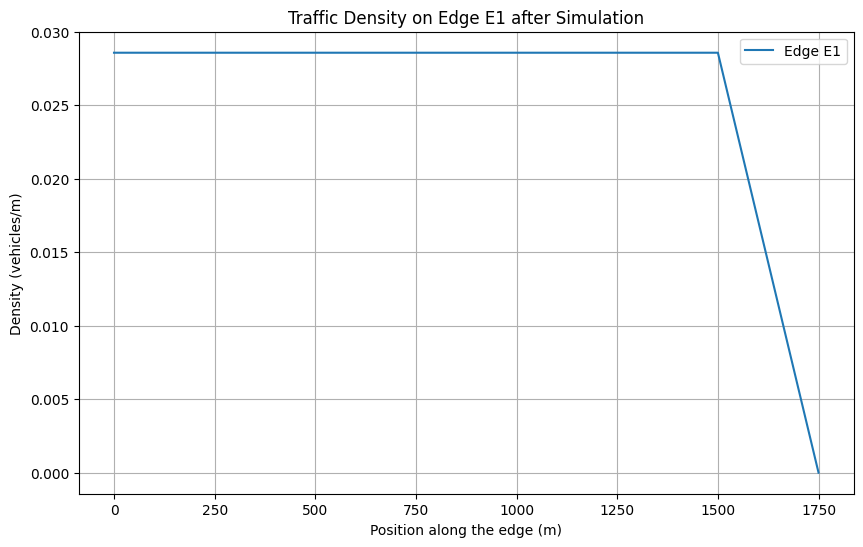

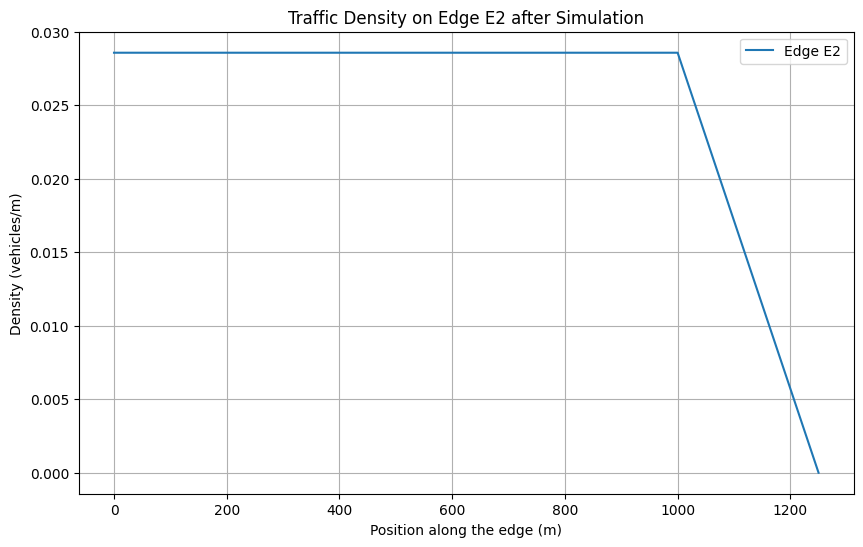

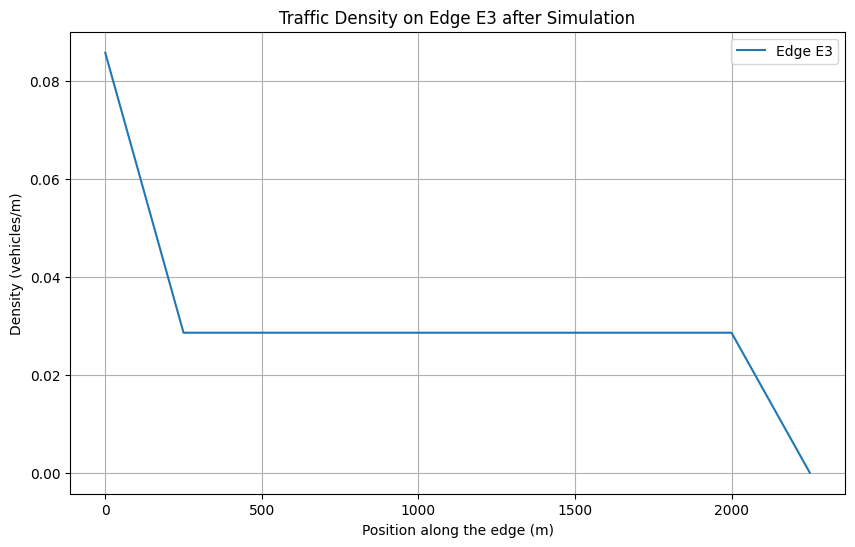

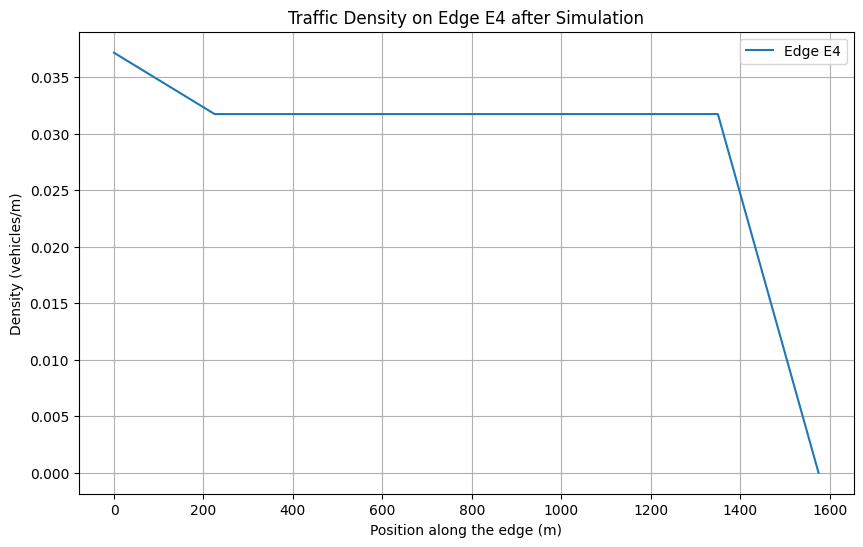

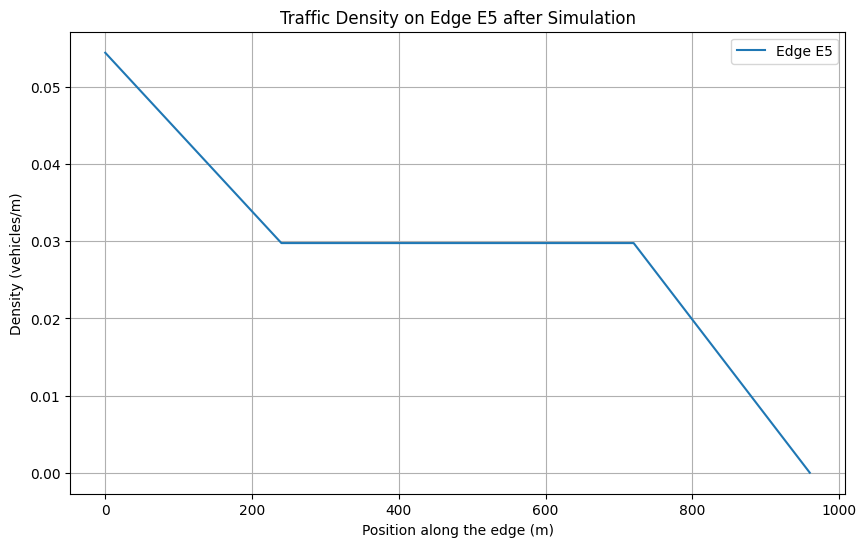

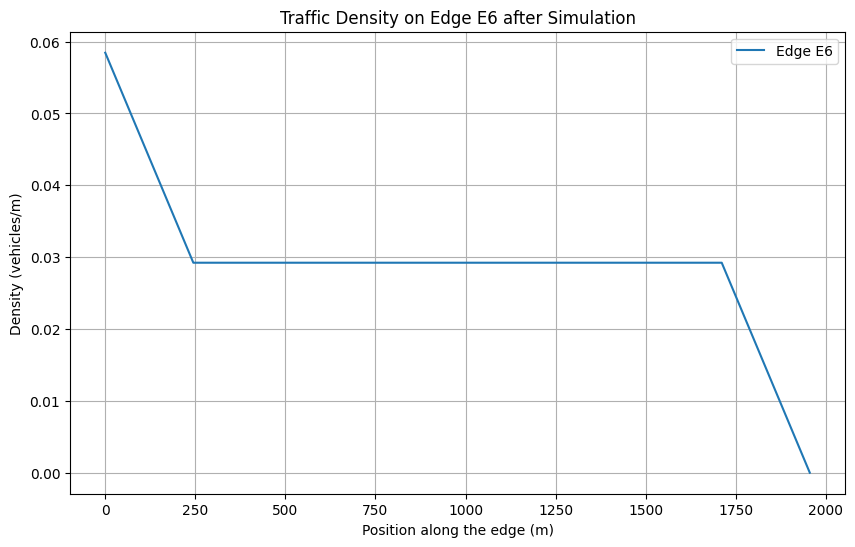

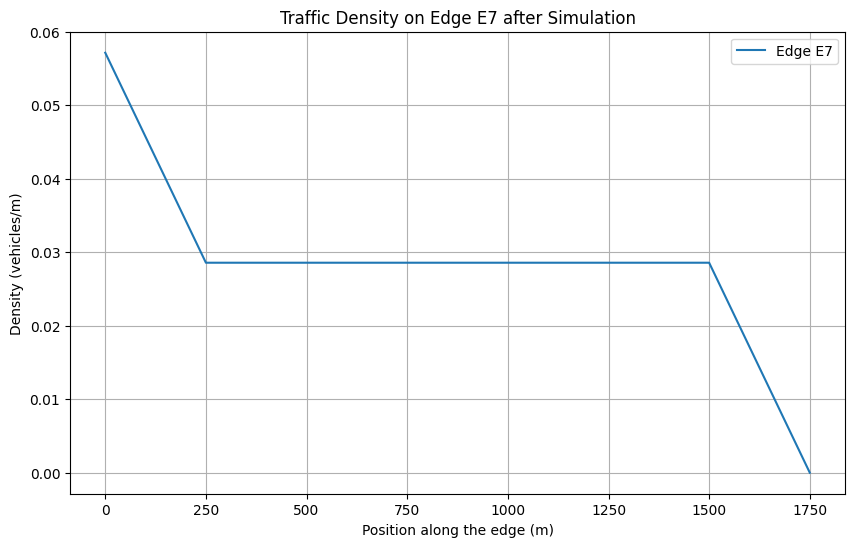

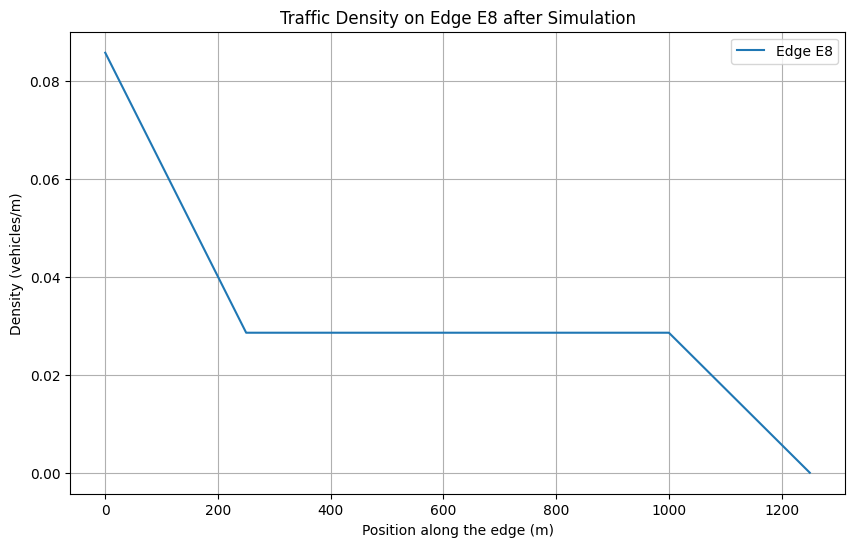

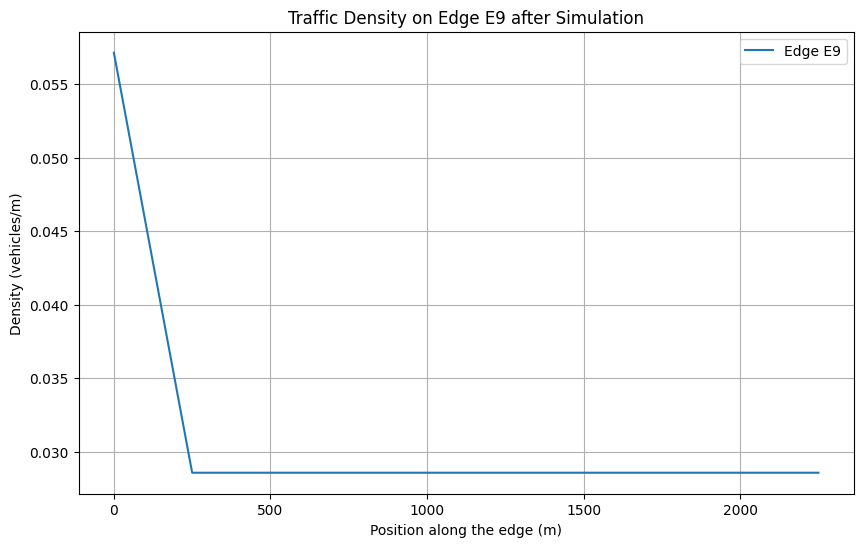

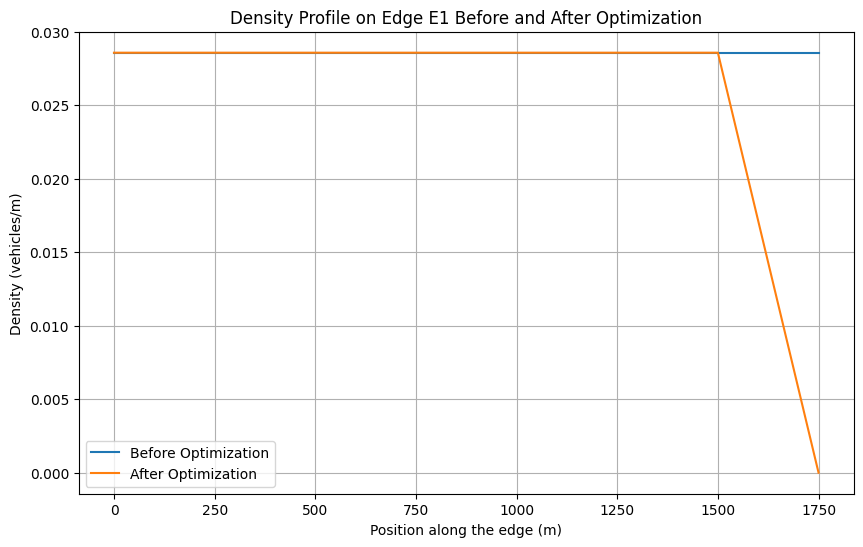

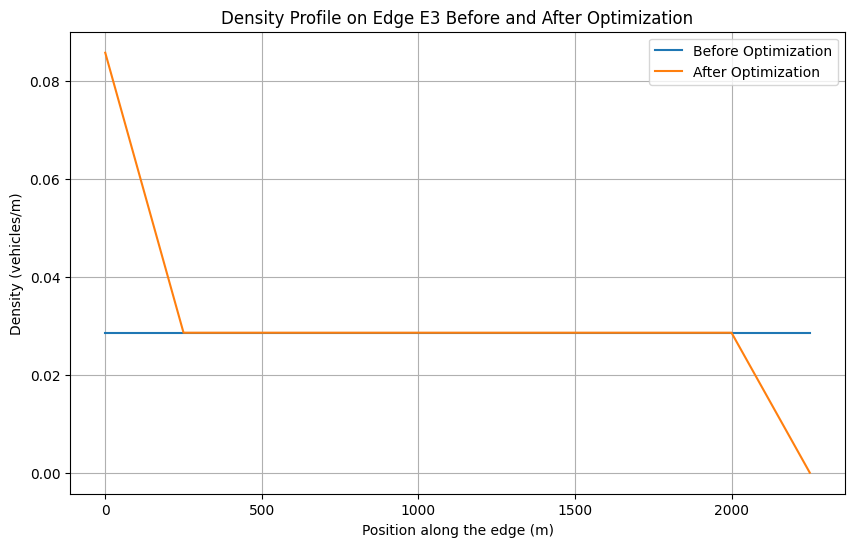

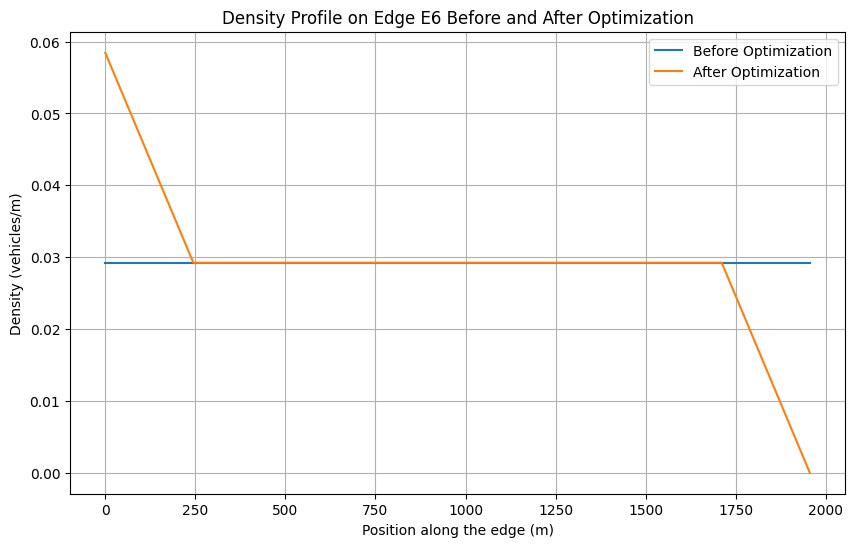

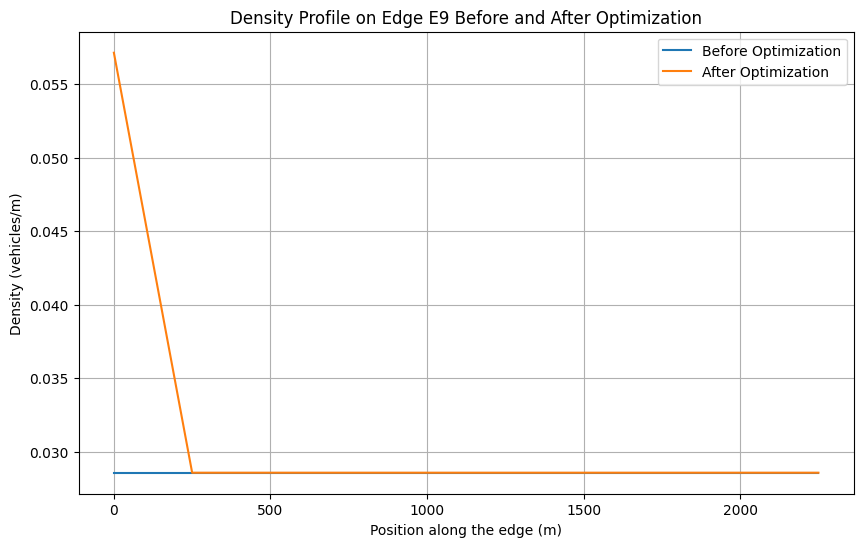

In [10]:
for edge_id, edge in edges.items():
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(edge.num_cells) * edge.delta_x, edge.density, label=f'Edge {edge_id}')
  plt.xlabel('Position along the edge (m)')
  plt.ylabel('Density (vehicles/m)')
  plt.title(f'Traffic Density on Edge {edge_id} after Simulation')
  plt.legend()
  plt.grid(True)
  plt.show()

for edge_id in ['E1', 'E3', 'E6', 'E9']:
  edge = edges[edge_id]
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(edge.num_cells) * edge.delta_x, edge.initial_density, label='Before Optimization')
  plt.plot(np.arange(edge.num_cells) * edge.delta_x, edge.optimized_density, label='After Optimization')
  plt.xlabel('Position along the edge (m)')
  plt.ylabel('Density (vehicles/m)')
  plt.title(f'Density Profile on Edge {edge_id} Before and After Optimization')
  plt.legend()
  plt.grid(True)
  plt.show()

# Optimized Transition Matrices

In [11]:
print("\nOptimized Transition Matrices:")
for intersection in intersections.values():
  print(f"\nIntersection {intersection.node_id}:")
  print(intersection.transition_matrix)


Optimized Transition Matrices:

Intersection I1:
[[1. 1.]]

Intersection I2:
[[0.17106781]
 [0.82893219]]

Intersection I3:
[[1.]]

Intersection I4:
[[1.]]

Intersection I5:
[[1. 1.]]

Intersection I6:
[[1.]]
